# Homework Week 6

## Load California Housing data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df_original = pd.read_csv('housing.csv')

In [3]:
df_original.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
columns = ['latitude','longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
           'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

df = df_original[columns]

In [5]:
df.shape

(20640, 10)

In [6]:
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
df.fillna(0, inplace=True)

<AxesSubplot: xlabel='median_house_value', ylabel='Count'>

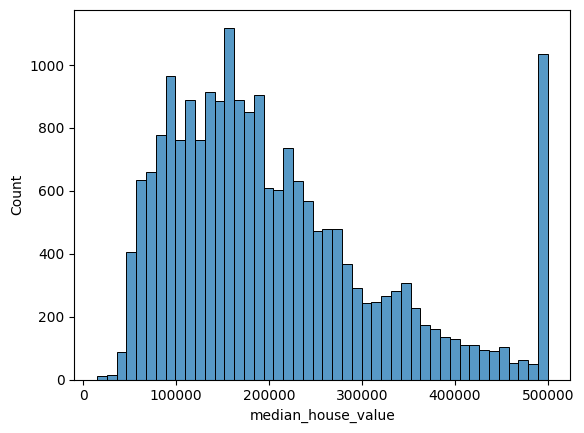

In [9]:
sns.histplot(df.median_house_value)

In [10]:
df.median_house_value = np.log1p(df.median_house_value)

<AxesSubplot: xlabel='median_house_value', ylabel='Count'>

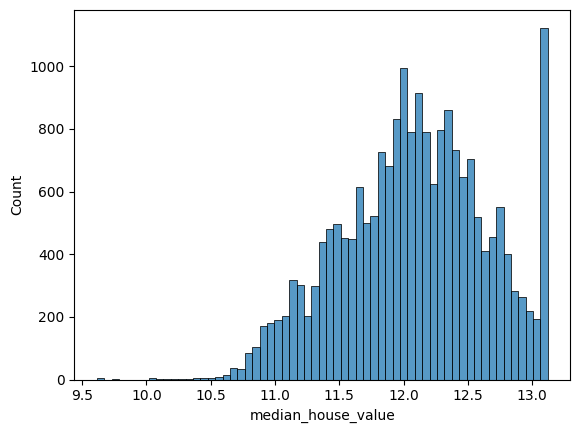

In [11]:
sns.histplot(df.median_house_value)

## Set up the validation framework

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
df_train.shape, df_val.shape, df_test.shape

((12384, 10), (4128, 10), (4128, 10))

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value']
y_val = df_val['median_house_value']
y_test = df_test['median_house_value']

X_train = df_train.drop('median_house_value', axis=1)
X_val = df_val.drop('median_house_value', axis=1)
X_test = df_test.drop('median_house_value', axis=1)

## Vectorize features and train a Decision Tree Regressor

In [15]:
from sklearn.feature_extraction import DictVectorizer

In [16]:
train_dict = X_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

In [17]:
from sklearn.tree import DecisionTreeRegressor

Max_depth is set to 1

In [18]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

## Question 1

**Which feature is used for splitting the data?**

In [19]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/Users/nineve/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Train a Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

## Question 2

**What's the RMSE of this model on validation?**

In [21]:
val_dict = X_val.to_dict(orient='records')
X_val = dv.transform(val_dict)


y_pred = rf.predict(X_val)

In [22]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_val, y_pred, squared=False)

In [23]:
round(rmse, 2)

0.25

## Fine-tuning the Random Forest model: number of estimators

Now let's experiment with the n_estimators parameter

In [24]:
n_estimators = np.arange(10, 201, 10)

scores = []

for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)

    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    scores.append((n, rmse))

df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'rmse'])

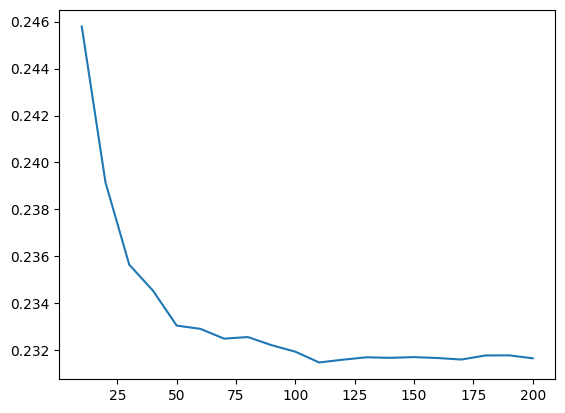

In [25]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

## Question 3

After which value of n_estimators does RMSE stop improving?

In [26]:
df_scores.iloc[df_scores.rmse.idxmin()][0]

110.0

I'll select 75 as the closest value to the answers in the homework multiple choice,
since it's better to have fewer estimators and the RMSE doesn't improve much after 75.

## Fine-tuning the Random Forest model: max_depth

In [27]:

max_depth = [10, 15, 20, 25]
scores = []
for d in max_depth:
    for n in n_estimators:
            rf = RandomForestRegressor(n_estimators=n, max_depth= d, random_state=1, n_jobs=-1)

            rf.fit(X_train, y_train)
    
            y_pred = rf.predict(X_val)
    
            rmse = mean_squared_error(y_val, y_pred, squared=False)
            scores.append((d, n, rmse))

df_scores = pd.DataFrame(scores, columns = ['max_depth', 'n_estimators', 'rmse'])

In [28]:
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.254601
1,10,20,0.252599
2,10,30,0.251514
3,10,40,0.250963
4,10,50,0.250117
...,...,...,...
75,25,160,0.231489
76,25,170,0.231449
77,25,180,0.231583
78,25,190,0.231552


## Question 4

What's the best max_depth?

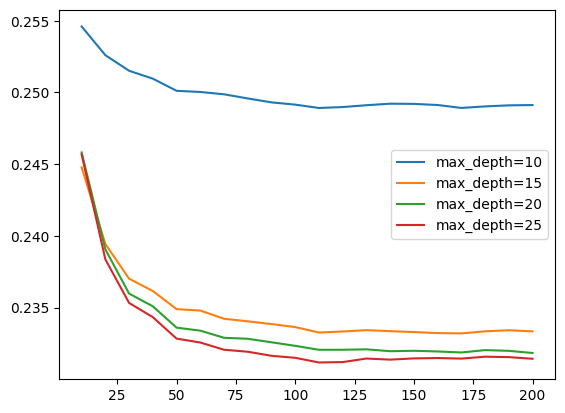

In [29]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

Max depth 25 has the lowest RMSE, but max_depth 20 has RSME values that are extremely close and is a smaller model, so will got for max_depth= 20 as the best value for this parameter.

## Extracting feature importance information

In [30]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
importances = rf.feature_importances_
features = dv.get_feature_names()
max(importances)

/Users/nineve/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0.3632241761204236

In [32]:
dict(zip(features, importances))

{'households': 0.016140755771256902,
 'housing_median_age': 0.03319673864709362,
 'latitude': 0.10133335065432272,
 'longitude': 0.09634054882440193,
 'median_income': 0.3632241761204236,
 'ocean_proximity=<1H OCEAN': 0.0027652480009874086,
 'ocean_proximity=INLAND': 0.3109008417080607,
 'ocean_proximity=ISLAND': 0.0003568062629475935,
 'ocean_proximity=NEAR BAY': 0.00045277051874698695,
 'ocean_proximity=NEAR OCEAN': 0.004452192019837238,
 'population': 0.030998886851355538,
 'total_bedrooms': 0.019372602815159373,
 'total_rooms': 0.020465081805406238}

## Question 5

**median_income** has the highest importance score

## Training an XGBoost Model

In [33]:
import xgboost as xgb

Create DMatrix for train and validation

In [46]:
features = dv.get_feature_names()

features = [w.replace('<', 'less_than') for w in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

Create a watchlist

In [47]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

Train model with eta = 0.3

In [48]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [49]:
s = output.stdout
print(s[:200])

[0]	train-rmse:8.12733	val-rmse:8.13245
[5]	train-rmse:1.40218	val-rmse:1.40741
[10]	train-rmse:0.34481	val-rmse:0.35782
[15]	train-rmse:0.23555	val-rmse:0.26044
[20]	train-rmse:0.21580	val-rmse:0.246


RMSE on validation set after 100 rounds = 0.246

Training model with eta=0.1

In [50]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [51]:
s = output.stdout
print(s[:200])

[0]	train-rmse:10.44372	val-rmse:10.44938
[5]	train-rmse:6.17513	val-rmse:6.17987
[10]	train-rmse:3.65741	val-rmse:3.66135
[15]	train-rmse:2.17500	val-rmse:2.17928
[20]	train-rmse:1.30499	val-rmse:1.3


RMSE on validation set after 100 rounds = 1.3

## Question 6

**Which eta leads to the best RMSE score on the validation dataset?**

'eta': 0.3
with an RMSE of 0.246